# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](https://compsci682.github.io/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from asgn1.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
  """
  Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
  it for the linear classifier. These are the same steps as we used for the
  SVM, but condensed to a single function.  
  """
  # Load the raw CIFAR-10 data
  cifar10_dir = 'datasets/cifar-10-batches-py'
  X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
  
  # subsample the data
  mask = range(num_training, num_training + num_validation)
  X_val = X_train[mask]
  y_val = y_train[mask]
  mask = range(num_training)
  X_train = X_train[mask]
  y_train = y_train[mask]
  mask = range(num_test)
  X_test = X_test[mask]
  y_test = y_test[mask]
  mask = np.random.choice(num_training, num_dev, replace=False)
  X_dev = X_train[mask]
  y_dev = y_train[mask]
  
  # Preprocessing: reshape the image data into rows
  X_train = np.reshape(X_train, (X_train.shape[0], -1))
  X_val = np.reshape(X_val, (X_val.shape[0], -1))
  X_test = np.reshape(X_test, (X_test.shape[0], -1))
  X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
  
  # Normalize the data: subtract the mean image
  mean_image = np.mean(X_train, axis = 0)
  X_train -= mean_image
  X_val -= mean_image
  X_test -= mean_image
  X_dev -= mean_image
  
  # add bias dimension and transform into columns
  X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
  X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
  X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
  X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
  
  return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', y_train.shape
print 'Validation data shape: ', X_val.shape
print 'Validation labels shape: ', y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape
print 'dev data shape: ', X_dev.shape
print 'dev labels shape: ', y_dev.shape

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **asgn1/classifiers/softmax.py**. 


In [3]:
# First implement the naive softmax loss function with nested loops.
# Open the file asgn1/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from asgn1.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print 'loss: %f' % loss
print 'sanity check: %f' % (-np.log(0.1))

loss: 2.410765
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *Fill this in*


In [4]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from asgn1.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 1e2)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 2.715921 analytic: 2.715921, relative error: 1.224345e-08
numerical: -2.293845 analytic: -2.293845, relative error: 2.759420e-08
numerical: 0.278379 analytic: 0.278379, relative error: 1.560542e-07
numerical: -2.143520 analytic: -2.143520, relative error: 1.483538e-08
numerical: 1.680983 analytic: 1.680983, relative error: 1.487934e-08
numerical: 1.417514 analytic: 1.417514, relative error: 5.104006e-08
numerical: -0.466666 analytic: -0.466666, relative error: 2.586014e-07
numerical: -1.255906 analytic: -1.255906, relative error: 5.347820e-08
numerical: 3.060125 analytic: 3.060124, relative error: 9.708068e-09
numerical: -2.315163 analytic: -2.315163, relative error: 1.264202e-08
numerical: 0.126864 analytic: 0.126863, relative error: 8.642985e-07
numerical: 0.348645 analytic: 0.348645, relative error: 1.647726e-07
numerical: 0.484229 analytic: 0.484228, relative error: 1.339880e-07
numerical: 0.736812 analytic: 0.736812, relative error: 6.544381e-08
numerical: -4.438535 ana

In [5]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'naive loss: %e computed in %fs' % (loss_naive, toc - tic)

from asgn1.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic)

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print 'Loss difference: %f' % np.abs(loss_naive - loss_vectorized)
print 'Gradient difference: %f' % grad_difference

naive loss: 2.410765e+00 computed in 0.118918s
vectorized loss: 2.410765e+00 computed in 0.011502s
Loss difference: 0.000000
Gradient difference: 0.000000


In [9]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from asgn1.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7, 4e-6,2e-5, 1e-4, 1e-3, 1e-2]
regularization_strengths = [5e4, 1e8, 1e2, 1e3, 1e1, 1e0]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
lr_rg_pairs = [(i, j) for i in learning_rates for j in regularization_strengths]
num_iterations = 1500
for lr, rg in lr_rg_pairs:
    softmax = Softmax()
    tic = time.time()
    loss_hist = softmax.train(X_train, y_train, learning_rate=lr, reg=rg, num_iters=num_iterations, verbose=True)
    toc = time.time()
    y_train_pred = softmax.predict(X_train)
    training_accuracy = np.mean(y_train == y_train_pred)
    print 'training accuracy: %f' % (training_accuracy, )
    y_val_pred = softmax.predict(X_val)
    validation_accuracy = np.mean(y_val == y_val_pred)
    print 'validation accuracy: %f' % (validation_accuracy, )
    results[(lr,rg)] = (training_accuracy,validation_accuracy ) 
    if(best_val<validation_accuracy):
        best_val = validation_accuracy
        best_softmax = softmax
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

iteration 0 / 1500: loss 780.315723
iteration 100 / 1500: loss 286.378155
iteration 200 / 1500: loss 106.050214
iteration 300 / 1500: loss 40.134367
iteration 400 / 1500: loss 16.073303
iteration 500 / 1500: loss 7.181867
iteration 600 / 1500: loss 3.993466
iteration 700 / 1500: loss 2.795794
iteration 800 / 1500: loss 2.302816
iteration 900 / 1500: loss 2.158113
iteration 1000 / 1500: loss 2.148770
iteration 1100 / 1500: loss 2.098611
iteration 1200 / 1500: loss 2.108801
iteration 1300 / 1500: loss 2.075056
iteration 1400 / 1500: loss 2.060259
training accuracy: 0.329510
validation accuracy: 0.343000
iteration 0 / 1500: loss 1530716.252004


asgn1/classifiers/softmax.py:100: RuntimeWarning: divide by zero encountered in log
  loss += 0.5*reg* np.sum(W*W)


iteration 100 / 1500: loss inf


asgn1/classifiers/softmax.py:102: RuntimeWarning: overflow encountered in double_scalars
  Mask[range(len(Mask)),y] = 1
asgn1/classifiers/softmax.py:102: RuntimeWarning: overflow encountered in multiply
  Mask[range(len(Mask)),y] = 1


iteration 200 / 1500: loss inf
iteration 300 / 1500: loss inf


asgn1/classifiers/softmax.py:109: RuntimeWarning: overflow encountered in multiply
  #                          END OF YOUR CODE                                 #


iteration 400 / 1500: loss nan
iteration 500 / 1500: loss nan
iteration 600 / 1500: loss nan
iteration 700 / 1500: loss nan
iteration 800 / 1500: loss nan
iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
training accuracy: 0.100265
validation accuracy: 0.087000
iteration 0 / 1500: loss 7.563609
iteration 100 / 1500: loss 5.769113
iteration 200 / 1500: loss 5.371909
iteration 300 / 1500: loss 4.838592
iteration 400 / 1500: loss 4.789261
iteration 500 / 1500: loss 4.536981
iteration 600 / 1500: loss 4.419506
iteration 700 / 1500: loss 4.254576
iteration 800 / 1500: loss 4.295542
iteration 900 / 1500: loss 4.642167
iteration 1000 / 1500: loss 4.162913
iteration 1100 / 1500: loss 3.916393
iteration 1200 / 1500: loss 4.026946
iteration 1300 / 1500: loss 4.189381
iteration 1400 / 1500: loss 3.935185
training accuracy: 0.250163
validation accuracy: 0.24

asgn1/classifiers/softmax.py:93: RuntimeWarning: overflow encountered in subtract
  total_exp_scores = np.sum(exp_scores, axis=1)
asgn1/classifiers/softmax.py:93: RuntimeWarning: invalid value encountered in subtract
  total_exp_scores = np.sum(exp_scores, axis=1)


iteration 600 / 1500: loss nan
iteration 700 / 1500: loss nan
iteration 800 / 1500: loss nan
iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
training accuracy: 0.100265
validation accuracy: 0.087000
iteration 0 / 1500: loss 1541807.474025
iteration 100 / 1500: loss nan
iteration 200 / 1500: loss nan
iteration 300 / 1500: loss nan
iteration 400 / 1500: loss nan
iteration 500 / 1500: loss nan
iteration 600 / 1500: loss nan
iteration 700 / 1500: loss nan
iteration 800 / 1500: loss nan
iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
training accuracy: 0.100265
validation accuracy: 0.087000
iteration 0 / 1500: loss 6.353024
iteration 100 / 1500: loss 45.387151
iteration 200 / 1500: loss 48.467244
iteration 300

In [10]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print 'softmax on raw pixels final test set accuracy: %f' % (test_accuracy, )

softmax on raw pixels final test set accuracy: 0.388000


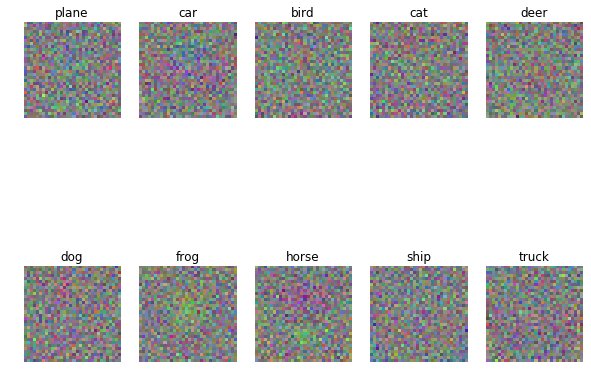

In [11]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):
  plt.subplot(2, 5, i + 1)
  
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])